In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*5)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.75:46429 Dashboard: http://10.148.0.75:8787/status,Cluster Workers: 7 Cores: 7 Memory: 111.79 GiB


_________
# 1. Read dataset



## Raw output

In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_B = xr.open_zarr(out_dir_zarr+'Buoy_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/22)
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...          ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) float32 ...
    rAs         (lat_g, lon) float32 ...
  * depth_left  (depth_left) float64 -0.035 1.035 2.18 ... 878.0 922.9 968.9
Data variables:
    U           (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1,

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic, boundary=None):
  * center   depth --> left
  * left     depth_left --> center


# Filtered

In [7]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')

In [8]:
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_1day_lowpass_filter.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_1day_lowpass_filter.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_1day_lowpass_filter.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_zarr+'B_1day_lowpass_filter.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_filter = ds_filter.assign_coords(time=time_day) 
print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...            ...
    dxG           (lat_g, lon) float32 ...
    dyG           (lat, lon_g) float32 ...
    rA            (lat, lon) float32 ...
    rAz           (lat_g, lon_g) float32 ...
    rAw           (lat, lon_g) float32 ...
    rAs           (lat_g, lon) float32 ...
Data variables:
    U_low_filter  (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    V_l

______________
# 2. Parameter

## 2.1 Frontogenesis (e.g., Fs and grad b)

In [9]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')

db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

du_dx_ij = gridx.diff(ds['U'], 'X')/gridx.interp(ds.dxG, 'Y')

dU_dy_1 = gridx.diff(ds['U'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')

dV_dx_1 = gridx.diff(ds['V'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')

dv_dy_ij = gridx.diff(ds['V'], 'Y')/gridx.interp(ds.dyG, 'X')

Fs = -(du_dx_ij*db_dx_ij*db_dx_ij + dv_dx_ij*db_dx_ij*db_dy_ij + du_dy_ij*db_dx_ij*db_dy_ij + dv_dy_ij*db_dy_ij*db_dy_ij)
lateral_buoyancy_gradient = np.sqrt(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij)

In [10]:
db_dx = gridx.diff(ds_filter['B_low_filter'],'X')/ds_filter.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')

db_dy = gridx.diff(ds_filter['B_low_filter'],'Y')/ds_filter.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

du_dx_ij = gridx.diff(ds_filter['U_low_filter'], 'X')/gridx.interp(ds_filter.dxG, 'Y')

dU_dy_1 = gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds_filter.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')

dV_dx_1 = gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds_filter.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')

dv_dy_ij = gridx.diff(ds_filter['V_low_filter'], 'Y')/gridx.interp(ds_filter.dyG, 'X')

Fs_filter = -(du_dx_ij*db_dx_ij*db_dx_ij + dv_dx_ij*db_dx_ij*db_dy_ij + du_dy_ij*db_dx_ij*db_dy_ij + dv_dy_ij*db_dy_ij*db_dy_ij)
lateral_buoyancy_gradient_filter = np.sqrt(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij)

## 2.2 Relative vorticity

In [9]:
zeta_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') - gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
zeta_filter_ij = gridx.interp(gridx.interp(zeta_filter, 'Y'), 'X')
zeta_filter_f = (zeta_filter_ij/f_ij)

## 2.3 Horizontal strain

In [10]:
strain_filter = (gridx.diff(ds_filter['U_low_filter'] * ds.dyG, 'X') - gridx.diff(ds_filter['V_low_filter']* ds.dxG, 'Y')) / ds.rA
strain_filter_f = (strain_filter/f_ij)
strain_filter_f = strain_filter_f.drop(['XC','YC','CS','SN','Depth','rA'])

___________
# 3. Save estimates

In [11]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [12]:
# ~7 mins
VV = ['zeta_filter_f']

for depth in depth_all:
    
    for vv in VV:
        
        zeta_single = zeta_filter_f.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        zeta_single = zeta_single.chunk(chunks)
        zeta_single = np.real(zeta_single).rename('zeta_single')     
        zeta_single = zeta_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        zeta_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [15]:
#  4 mins
VV = ['lbg_filter']

for depth in depth_all:
    
    for vv in VV:
        
        lbg_single = lateral_buoyancy_gradient_filter.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        lbg_single = lbg_single.chunk(chunks)
        lbg_single = np.real(lbg_single).rename('lbg_single')     
        lbg_single = lbg_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        lbg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [14]:
#  12 mins
VV = ['Fs_filter']

for depth in depth_all:
    
    for vv in VV:
        
        Fs_single = Fs_filter.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        Fs_single = Fs_single.chunk(chunks)
        Fs_single = np.real(Fs_single).rename('Fs_single')     
        Fs_single = Fs_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        Fs_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [13]:
#  6 mins
VV = ['strain_filter_f']

for depth in depth_all:
    
    for vv in VV:
        
        strain_single = strain_filter_f.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        strain_single = strain_single.chunk(chunks)
        strain_single = np.real(strain_single).rename('strain_single')     
        strain_single = strain_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        strain_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

# 4. Read results

In [5]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'lbg_filter_d%02d.zarr'%(depth)) for depth in range(52)]
lbg = xr.concat(D, dim='depth')
lbg = lbg.lbg_single
lbg

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [6]:
D = [xr.open_zarr(out_dir_store+'Fs_filter_d%02d.zarr'%(depth)) for depth in range(52)]
Fs = xr.concat(D, dim='depth')
Fs = Fs.Fs_single
Fs

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [8]:
D = [xr.open_zarr(out_dir_store+'zeta_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
zeta = xr.concat(D, dim='depth')
zeta = zeta.zeta_single
zeta

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [8]:
D = [xr.open_zarr(out_dir_store+'strain_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
strain = xr.concat(D, dim='depth')
strain = strain.strain_single
strain

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [23]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'Tb_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
Tb = xr.concat(D, dim='depth')
Tb = Tb.Tb_single
Tb

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


____________
## KE forward cascade and frontogenesis

In [7]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_8km_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_8km = xr.concat(D, dim='depth')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg_8km = PI_cg_8km.assign_coords(time=time_day) 
print(PI_cg_8km)

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Dimensions without coordinates: depth
Data variables:
    PI_cg_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>


In [11]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_30km_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_30km = xr.concat(D, dim='depth')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg_30km = PI_cg_30km.assign_coords(time=time_day) 
print(PI_cg_30km)

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Dimensions without coordinates: depth
Data variables:
    PI_cg_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>


In [8]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'
D = [xr.open_zarr(out_dir_store+'PI_cg_1d_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_1d = xr.concat(D, dim='depth')
PI_cg_1d = PI_cg_1d.PI_cg_1d_single
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg_1d = PI_cg_1d.assign_coords(time=time_day) 

print(PI_cg_1d)
print('\n data size: %.1f GB' %(PI_cg_1d.nbytes / 1e9))

<xarray.DataArray 'PI_cg_1d_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00

 data size: 69.7 GB


In [9]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'
D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_5d = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg_5d.PI_cg_5d_single
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg_5d = PI_cg_5d.assign_coords(time=time_day) 
print(PI_cg_5d)
print('\n data size: %.1f GB' %(PI_cg_5d.nbytes / 1e9))

<xarray.DataArray 'PI_cg_5d_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Dimensions without coordinates: depth

 data size: 69.7 GB


___________
# Figures of snapshots

Text(0.5, 1.0, 'Tb')

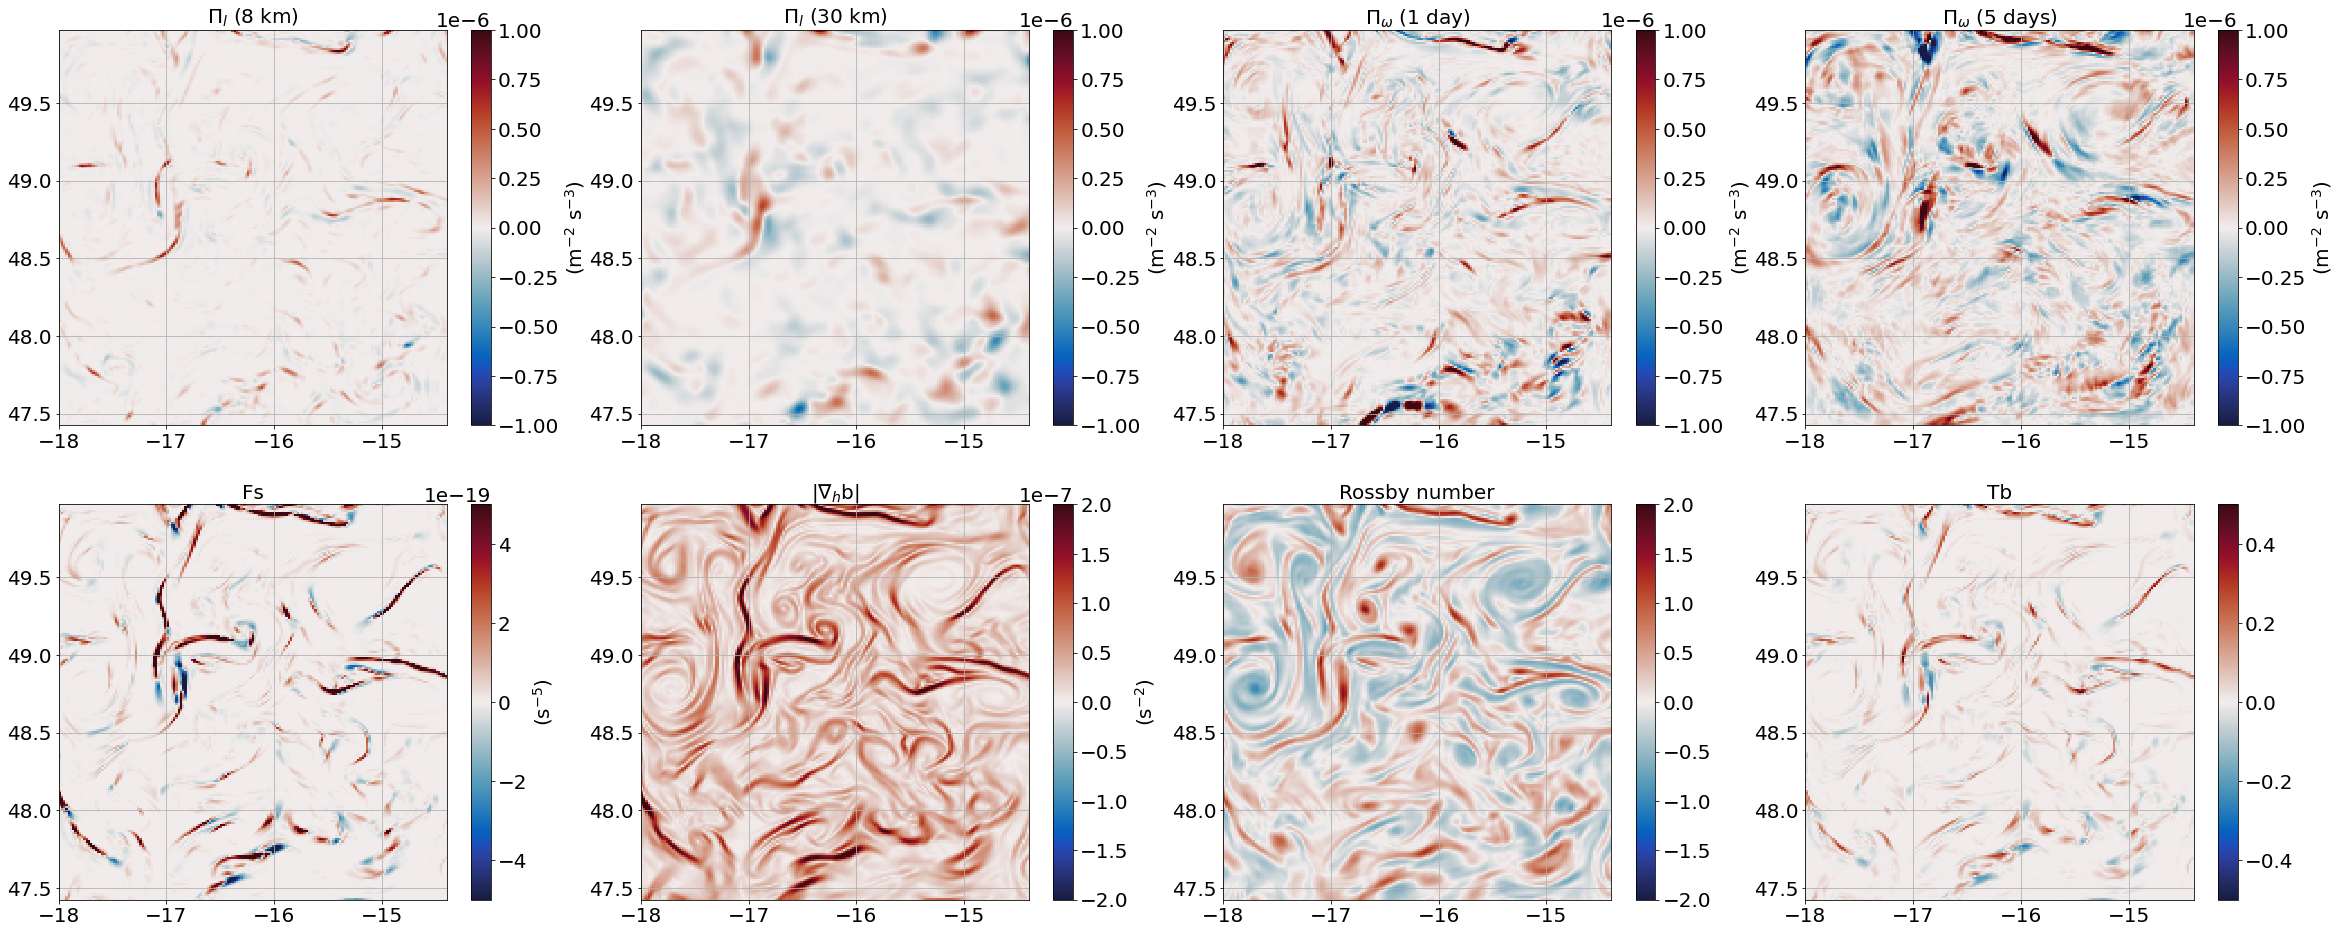

In [14]:
plt.rc('font', size=20) 
font_size=20

Time = '2012-03-02T00:00:00'

fig, ax = plt.subplots(figsize=(40,16))

ax = plt.subplot(241)
cax = PI_cg_8km.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{l}$ (8 km)',fontsize=font_size)

ax = plt.subplot(242)
cax = PI_cg_30km.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{l}$ (30 km)',fontsize=font_size)

ax = plt.subplot(243)
cax = PI_cg_1d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (1 day)',fontsize=font_size)

ax = plt.subplot(244)
cax = PI_cg_5d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (5 days)',fontsize=font_size)


ax = plt.subplot(245)
cax = Fs.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-5e-19, vmax=5e-19, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-5}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Fs',fontsize=font_size)

ax = plt.subplot(246)
cax = lbg.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-2e-7, vmax=2e-7, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-2}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title(r'|$\nabla_h$b|',fontsize=font_size)

ax = plt.subplot(247)
cax = zeta.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-2, vmax=2, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Rossby number',fontsize=font_size)

ax = plt.subplot(248)
cax = Tb.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Tb',fontsize=font_size)


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/KE_flux_forcing_snapshot.png')

(48.4, 49.2)

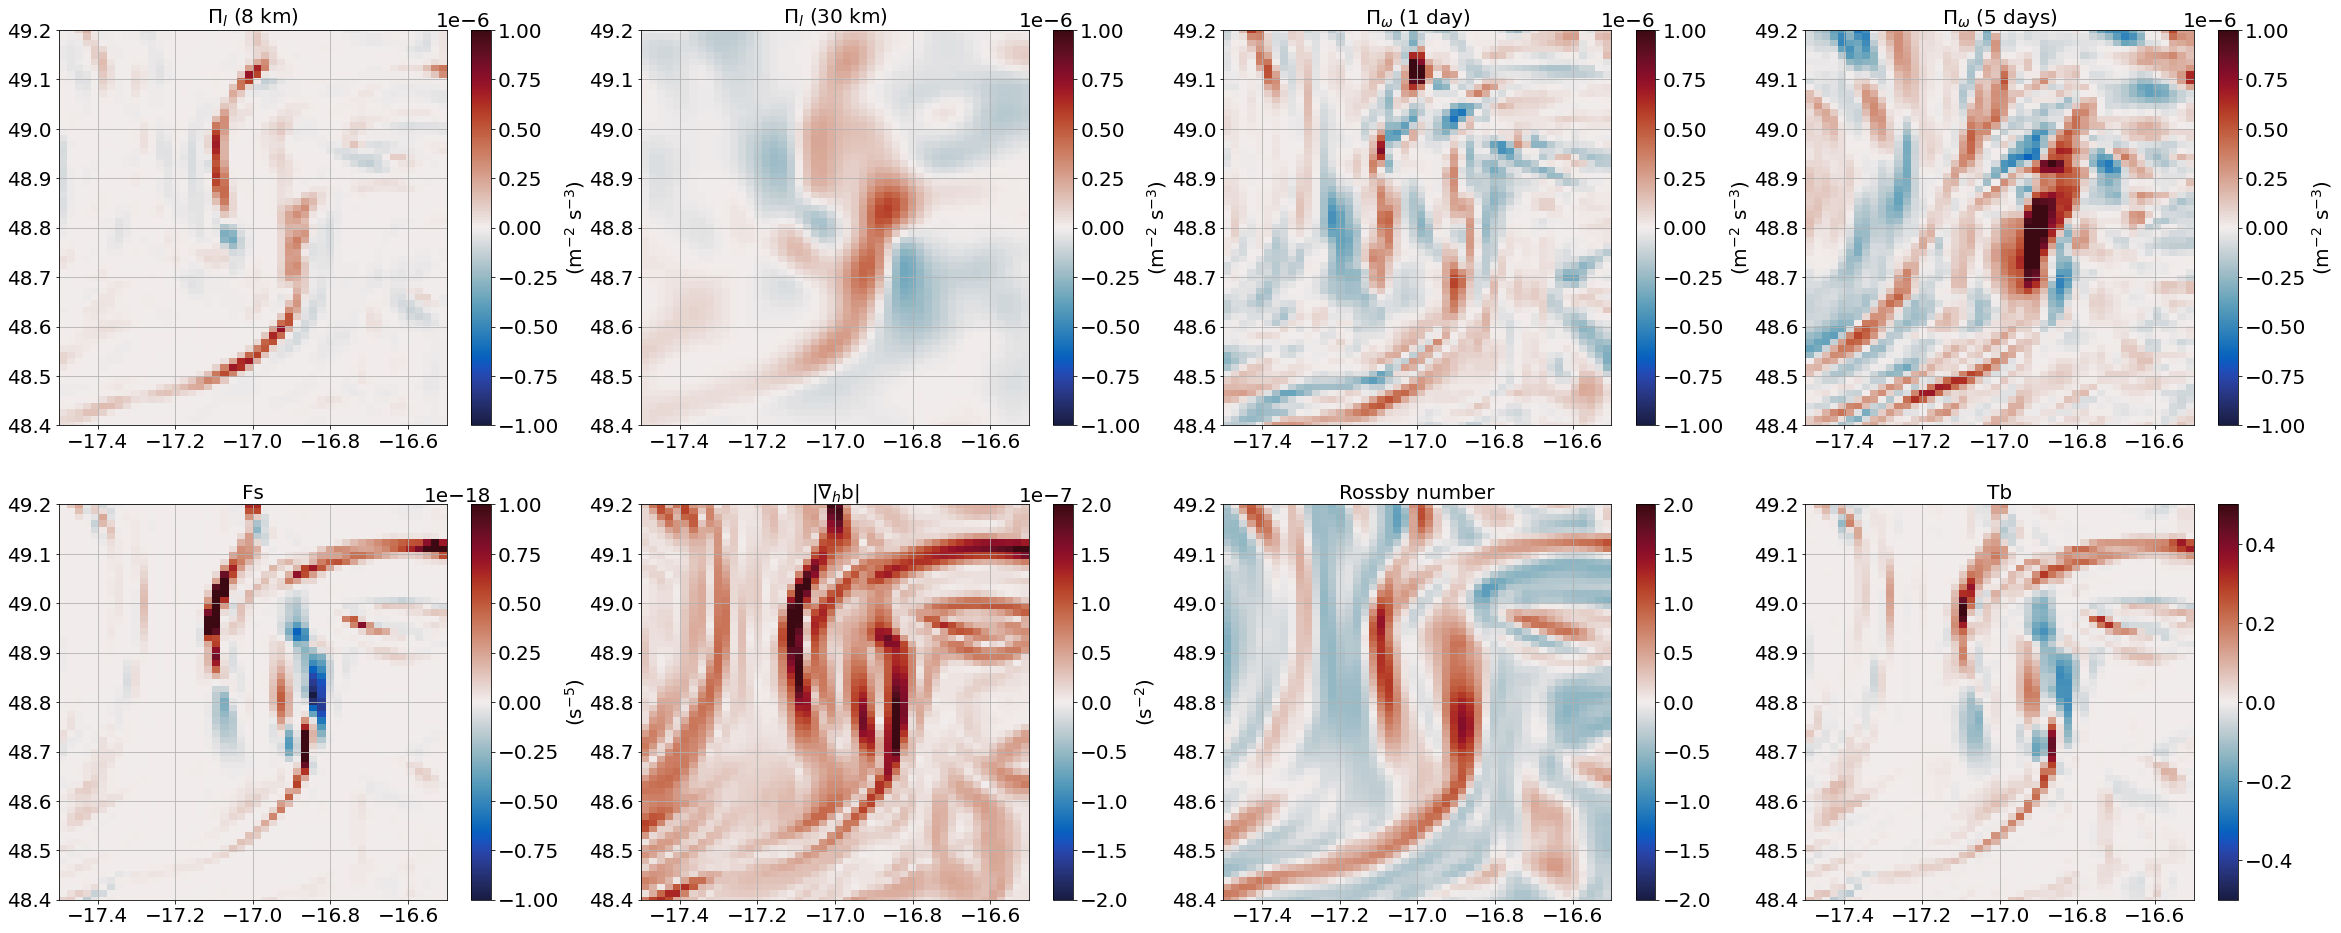

In [18]:
plt.rc('font', size=20) 
font_size=20

Time = '2012-03-02T00:00:00'

fig, ax = plt.subplots(figsize=(40,16))

ax = plt.subplot(241)
cax = PI_cg_8km.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{l}$ (8 km)',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(242)
cax = PI_cg_30km.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{l}$ (30 km)',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(243)
cax = PI_cg_1d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (1 day)',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(244)
cax = PI_cg_5d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (5 days)',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])


ax = plt.subplot(245)
cax = Fs.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-5}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Fs',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(246)
cax = lbg.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-2e-7, vmax=2e-7, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-2}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title(r'|$\nabla_h$b|',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(247)
cax = zeta.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-2, vmax=2, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Rossby number',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(248)
cax = Tb.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Tb',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/KE_flux_forcing_snapshot.png')

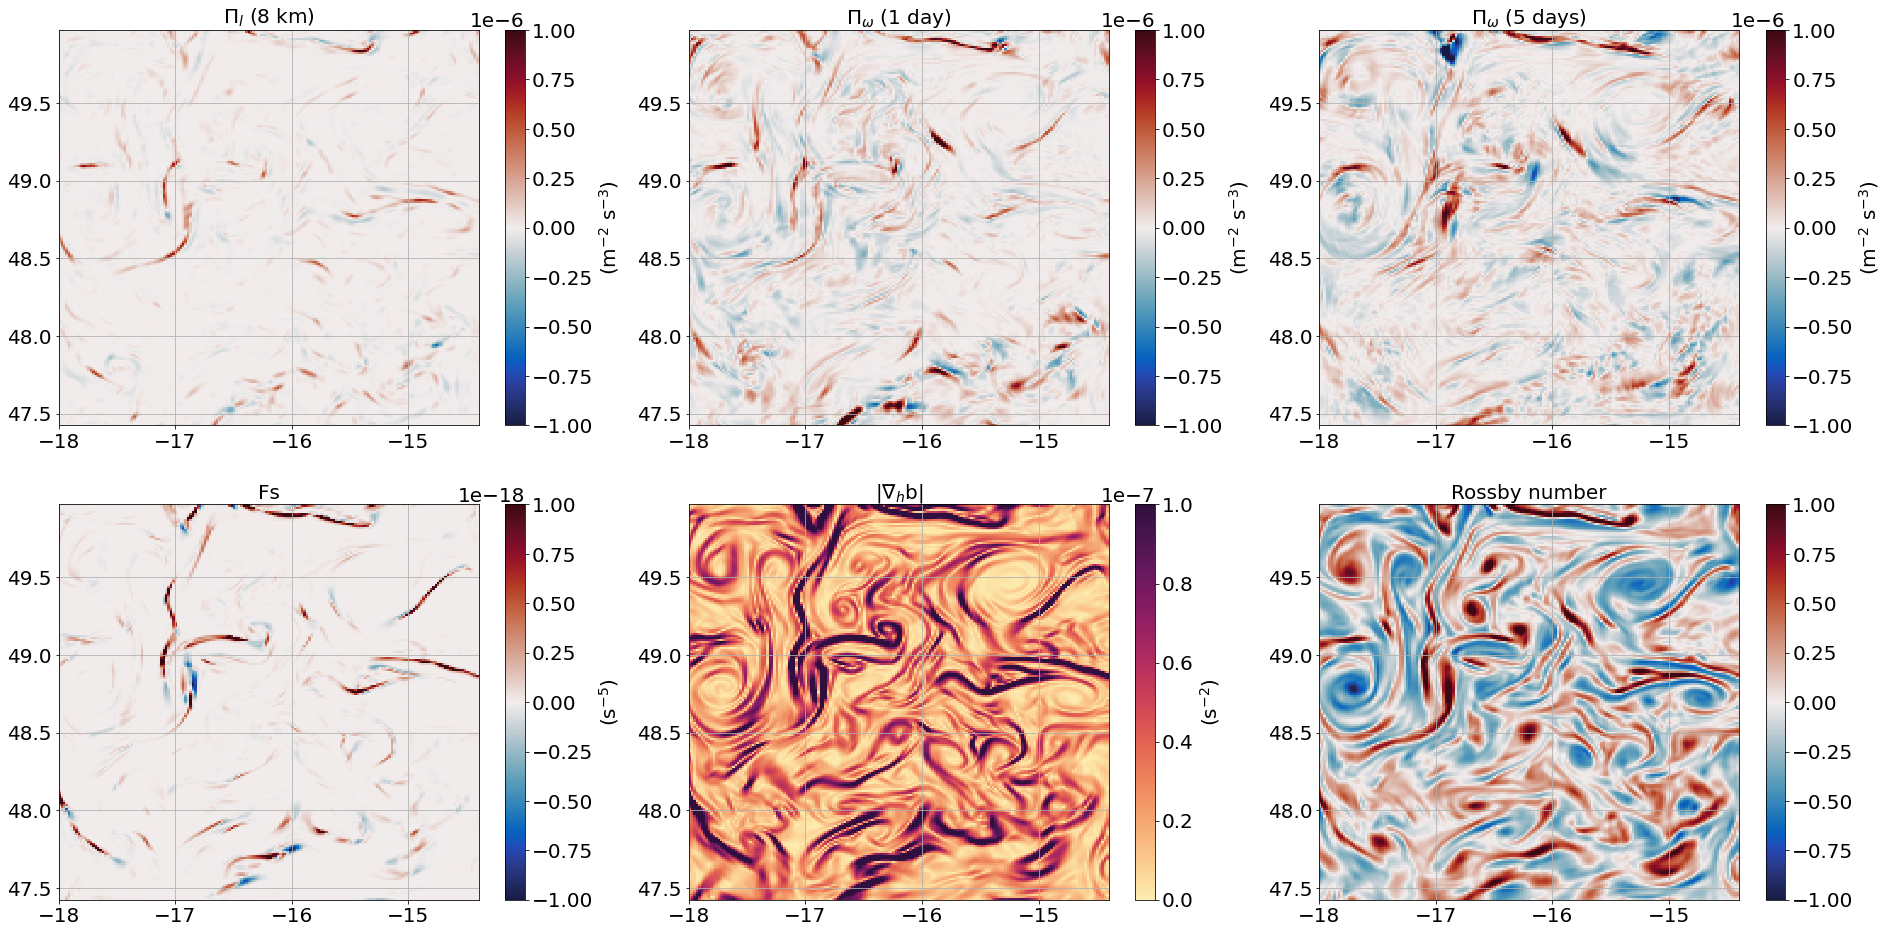

In [20]:
plt.rc('font', size=20) 
font_size=20

Time = '2012-03-02T00:00:00'

fig, ax = plt.subplots(figsize=(32,16))

ax = plt.subplot(231)
cax = PI_cg_8km.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{l}$ (8 km)',fontsize=font_size)

ax = plt.subplot(232)
cax = PI_cg_1d.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (1 day)',fontsize=font_size)

ax = plt.subplot(233)
cax = PI_cg_5d.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (5 days)',fontsize=font_size)


ax = plt.subplot(234)
cax = Fs.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-5}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Fs',fontsize=font_size)

ax = plt.subplot(235)
cax = lbg.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=0, vmax=1e-7, cmap=cm.matter, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-2}$)', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title(r'|$\nabla_h$b|',fontsize=font_size)

ax = plt.subplot(236)
cax = zeta.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('', fontsize=font_size)
ax.grid()
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Rossby number',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/KE_flux_forcing_snapshot.png')

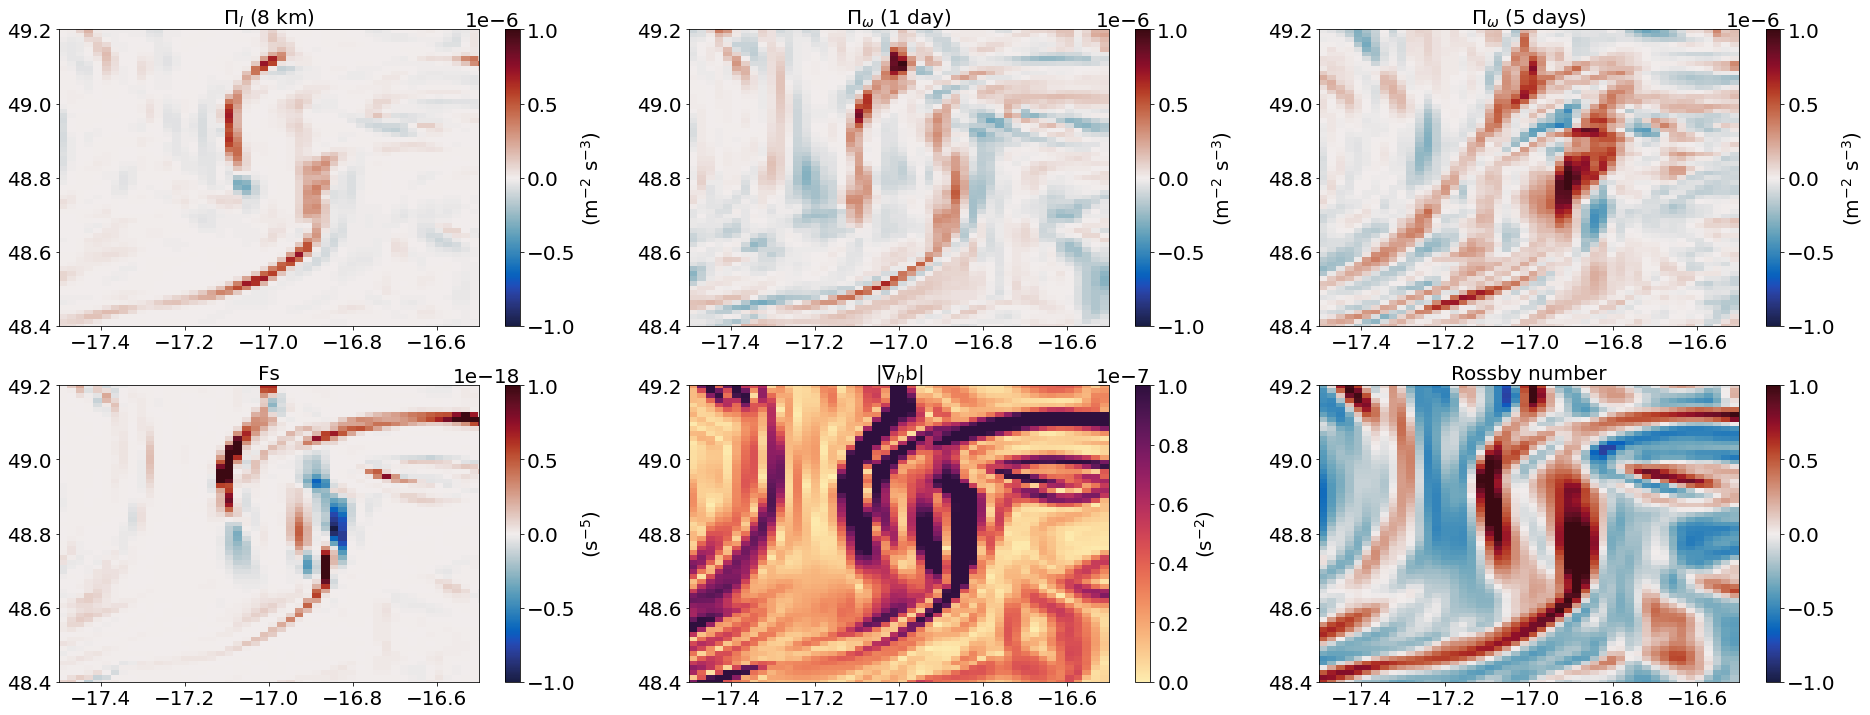

In [21]:
plt.rc('font', size=20) 
font_size=20

Time = '2012-03-02T00:00:00'

fig, ax = plt.subplots(figsize=(32,12))

ax = plt.subplot(231)
cax = PI_cg_8km.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{l}$ (8 km)',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(232)
cax = PI_cg_1d.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (1 day)',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(233)
cax = PI_cg_5d.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-6,vmax=1e-6, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (5 days)',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(234)
cax = Fs.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-5}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Fs',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(235)
cax = lbg.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=0, vmax=1e-7, cmap=cm.matter, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-2}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title(r'|$\nabla_h$b|',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

ax = plt.subplot(236)
cax = zeta.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Rossby number',fontsize=font_size)
ax.set_xlim([-17.5, -16.5])
ax.set_ylim([48.4, 49.2])

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/KE_flux_forcing_snapshot_zoomin.png')

Text(0.5, 1.0, '$\\Pi_{\\omega}$ (5 days)')

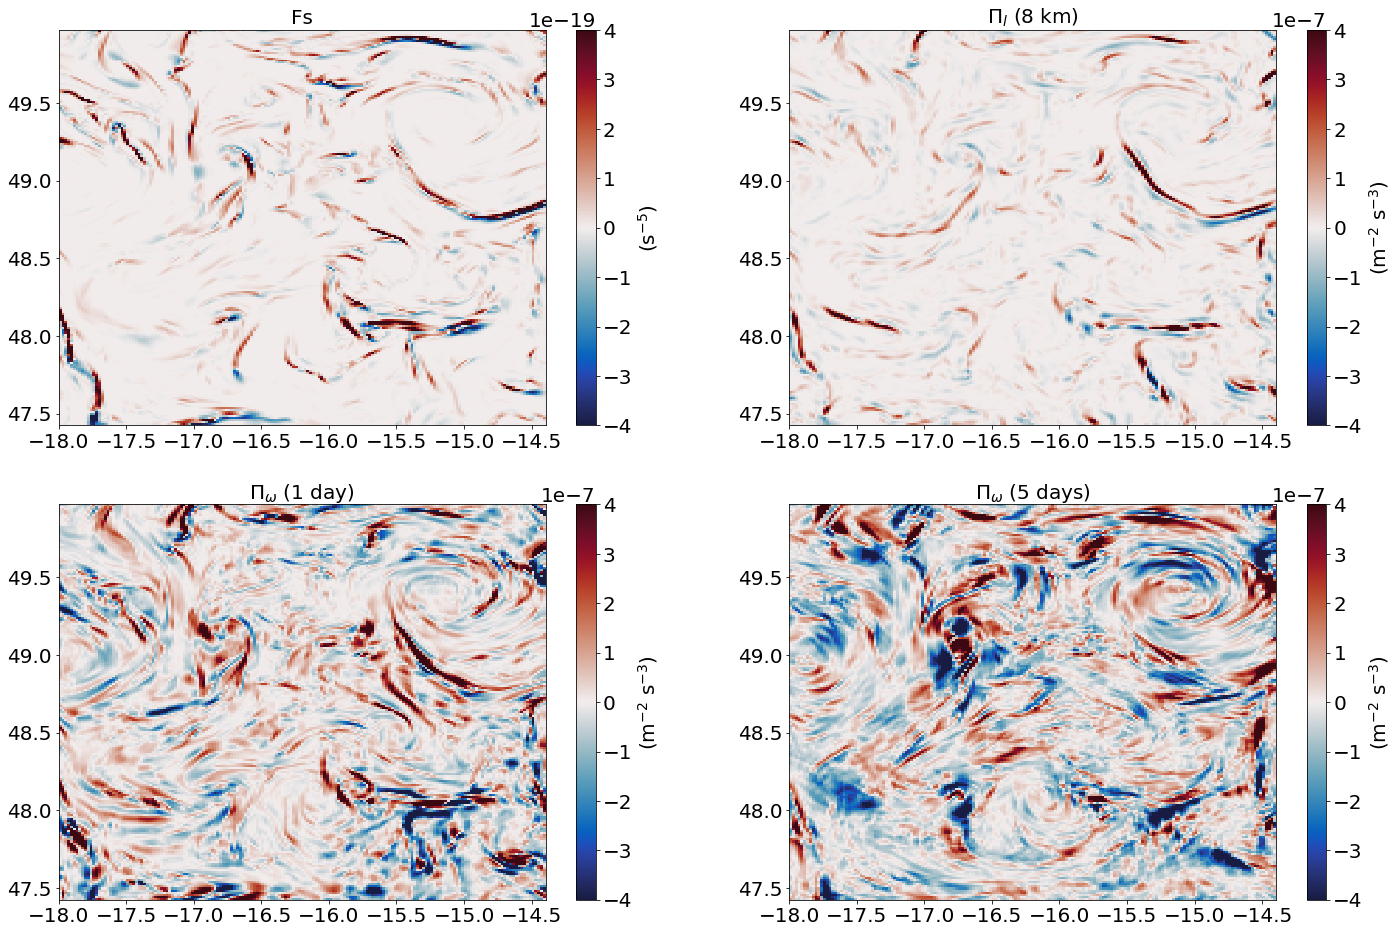

In [20]:
plt.rc('font', size=20) 
font_size=20

Time = '2012-03-07T00:00:00'

fig, ax = plt.subplots(figsize=(24,16))

ax = plt.subplot(221)
cax = Fs.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-4e-19, vmax=4e-19, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-5}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Fs',fontsize=font_size)

ax = plt.subplot(222)
cax = PI_cg_8km.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{l}$ (8 km)',fontsize=font_size)

ax = plt.subplot(223)
cax = PI_cg_1d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (1 day)',fontsize=font_size)

ax = plt.subplot(224)
cax = PI_cg_5d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (5 days)',fontsize=font_size)


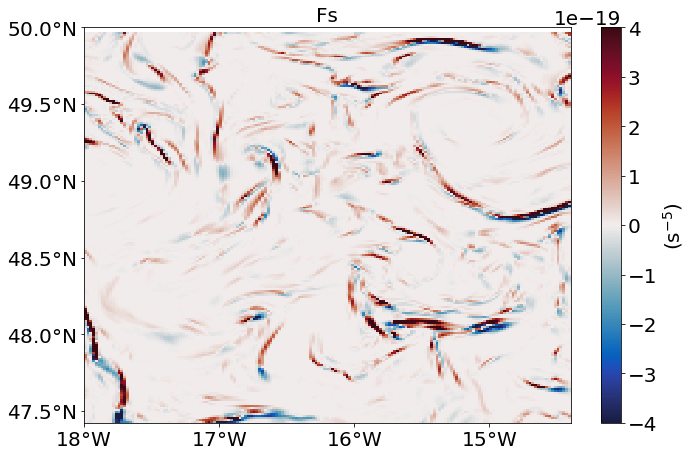

In [26]:
plt.rc('font', size=20) 
font_size=20

Time = '2012-03-07T00:00:00'

fig, ax = plt.subplots(figsize=(24,16))

ax = plt.subplot(221)
cax = Fs.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-4e-19, vmax=4e-19, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-5}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Fs',fontsize=font_size)
ax.set_xticks([-18,-17,-16,-15])
ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'], ha='center')
ax.set_yticks([47.5,48.0,48.5,49.0,49.5,50])
ax.set_yticklabels(['$47.5\degree$N','$48.0\degree$N','$48.5\degree$N','$49.0\degree$N','$49.5\degree$N','$50.0\degree$N'])

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/Save_figs/Fs_0423.png')

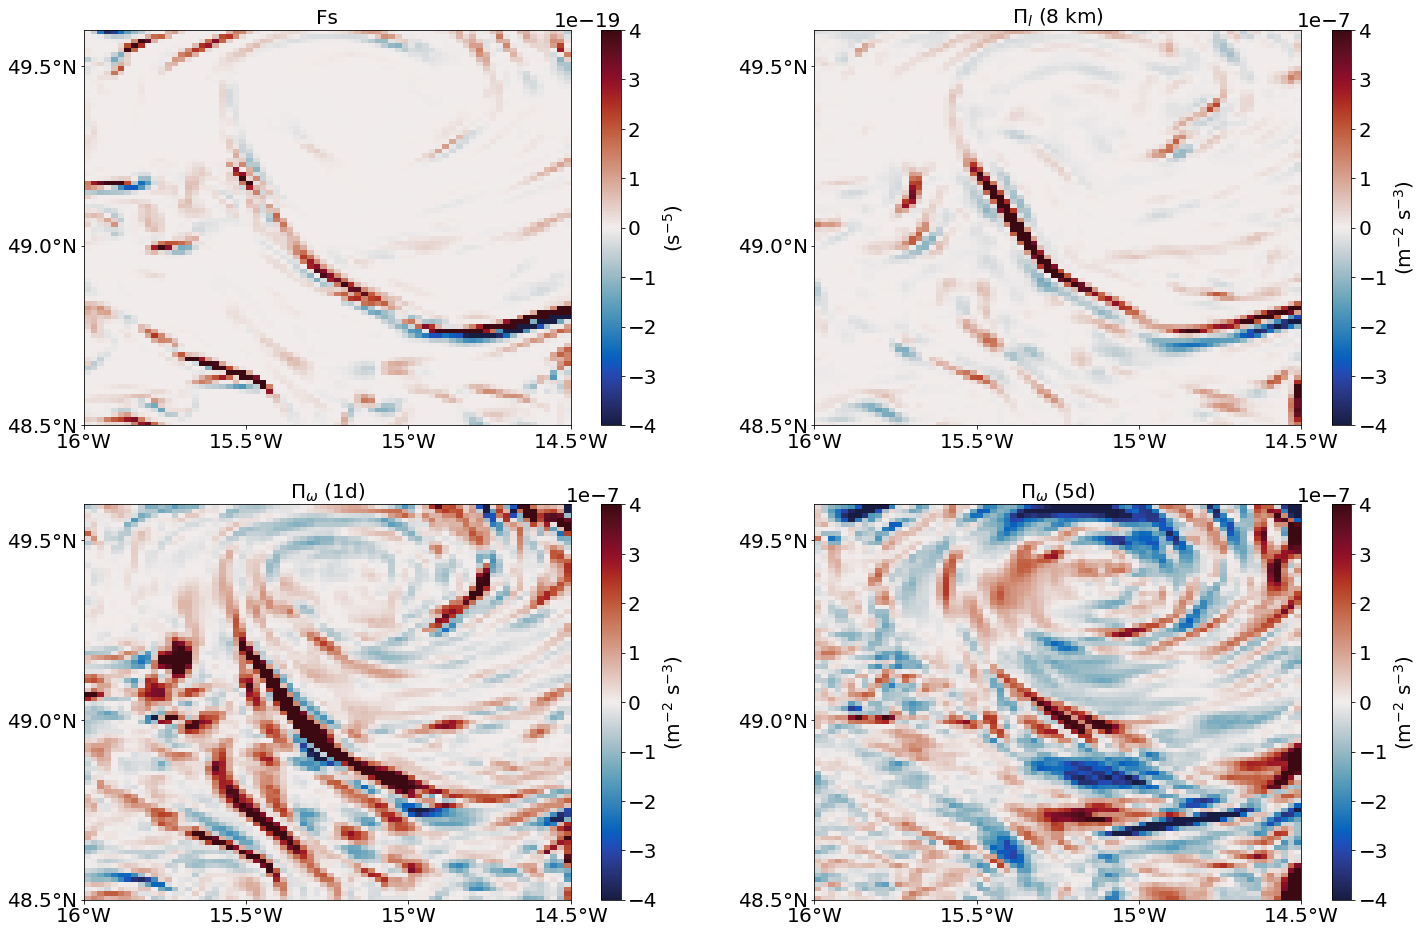

In [27]:
plt.rc('font', size=20) 
font_size=20

Time = '2012-03-07T00:00:00'

fig, ax = plt.subplots(figsize=(24,16))

ax = plt.subplot(221)
cax = Fs.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat', vmin=-4e-19, vmax=4e-19, cmap=cm.balance, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(s$^{-5}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Fs',fontsize=font_size)
ax.set_xlim([-16.0, -14.5])
ax.set_ylim([48.5, 49.6])
ax.set_xticks([-16,-15.5,-15,-14.5])
ax.set_xticklabels(['$16\degree$W','$15.5\degree$W','$15\degree$W','$14.5\degree$W'], ha='center')
ax.set_yticks([48.5,49.0,49.5])
ax.set_yticklabels(['$48.5\degree$N','$49.0\degree$N','$49.5\degree$N'])


ax = plt.subplot(222)
cax = PI_cg_8km.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{l}$ (8 km)',fontsize=font_size)
ax.set_xlim([-16.0, -14.5])
ax.set_ylim([48.5, 49.6])
ax.set_xticks([-16,-15.5,-15,-14.5])
ax.set_xticklabels(['$16\degree$W','$15.5\degree$W','$15\degree$W','$14.5\degree$W'], ha='center')
ax.set_yticks([48.5,49.0,49.5])
ax.set_yticklabels(['$48.5\degree$N','$49.0\degree$N','$49.5\degree$N'])

ax = plt.subplot(223)
cax = PI_cg_1d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (1d)',fontsize=font_size)
ax.set_xlim([-16.0, -14.5])
ax.set_ylim([48.5, 49.6])
ax.set_xticks([-16,-15.5,-15,-14.5])
ax.set_xticklabels(['$16\degree$W','$15.5\degree$W','$15\degree$W','$14.5\degree$W'], ha='center')
ax.set_yticks([48.5,49.0,49.5])
ax.set_yticklabels(['$48.5\degree$N','$49.0\degree$N','$49.5\degree$N'])

ax = plt.subplot(224)
cax = PI_cg_5d.isel(lat=slice(2,-2),lon=slice(2,-2), depth=0).sel(time=Time).plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('$\Pi_{\omega}$ (5d)',fontsize=font_size)
ax.set_xlim([-16.0, -14.5])
ax.set_ylim([48.5, 49.6])
ax.set_xticks([-16,-15.5,-15,-14.5])
ax.set_xticklabels(['$16\degree$W','$15.5\degree$W','$15\degree$W','$14.5\degree$W'], ha='center')
ax.set_yticks([48.5,49.0,49.5])
ax.set_yticklabels(['$48.5\degree$N','$49.0\degree$N','$49.5\degree$N'])

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/Save_figs/Fs_Pi_omega_snapshot_0423.png')

# Movies

In [15]:
from dask import compute, delayed
import sys
import cartopy.crs as ccrs
from mitequinox.plot import *

In [20]:
ndepth = 16

ds_movie = xr.merge([PI_cg_8km.PI_cg_single.rename('Pi_cg_8km').isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth), 
                     PI_cg_30km.PI_cg_single.rename('Pi_cg_30km').isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth),
                     PI_cg_1d.rename('Pi_cg_1d').isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth), 
                     PI_cg_5d.rename('Pi_cg_5d').isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth),
                     Fs.isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth),
                     lbg.isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth),
                     zeta.isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth),
                     Tb.isel(lat=slice(2,-2),lon=slice(2,-2), depth=ndepth)
                    ])
ds_movie

<xarray.Dataset>
Dimensions:      (lat: 197, lon: 173, time: 9415)
Coordinates:
  * lat          (lat) float64 47.43 47.44 47.46 47.47 ... 49.94 49.95 49.96
  * lon          (lon) float64 -17.99 -17.97 -17.95 ... -14.45 -14.43 -14.41
  * time         (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    depth        float64 52.69
Data variables:
    Pi_cg_8km    (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 173), meta=np.ndarray>
    Pi_cg_30km   (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 173), meta=np.ndarray>
    Pi_cg_1d     (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 173), meta=np.ndarray>
    Pi_cg_5d     (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 173), meta=np.ndarray>
    Fs_single    (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 173), meta=np.ndarray>
    lbg_single   (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 173), meta=np.ndarray>
    zeta_single  (lat, lon, time) float32 dask.array<chunksize=(1, 173, 9415), meta=np.ndarray>
    Tb_single    (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 173), meta=np.ndarray>

In [24]:
font_size = 20
linewidith = 4

def plot_scalar8(v1, v2, v3, v4, v5, v6, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                       offline=False, figsize=(40,16), cmap=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)

        try:
            
            plt.rc('font', size=20) 
            ax = plt.subplot(231)
            cax = v1.plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
            cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
            cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
            cbar.ax.tick_params(labelsize=font_size)
            ax.grid()
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            ax.set_title(title[0],fontsize=font_size) 
            ax.set_xticks([-18,-17,-16,-15])
            ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'], ha='center')
            ax.set_yticks([47.5,48.0,48.5,49.0,49.5,50])
            ax.set_yticklabels(['$47.5\degree$N','$48.0\degree$N','$48.5\degree$N','$49.0\degree$N','$49.5\degree$N','$50.0\degree$N'])

            ax = plt.subplot(232)
            cax = v2.plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
            cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
            cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
            cbar.ax.tick_params(labelsize=font_size)
            ax.grid()
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            ax.set_title('$\Pi_{\omega}$ (1 day)',fontsize=font_size)
            ax.set_xticks([-18,-17,-16,-15])
            ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'], ha='center')
            ax.set_yticks([47.5,48.0,48.5,49.0,49.5,50])
            ax.set_yticklabels(['$47.5\degree$N','$48.0\degree$N','$48.5\degree$N','$49.0\degree$N','$49.5\degree$N','$50.0\degree$N'])

            ax = plt.subplot(233)
            cax = v3.plot(x='lon', y='lat',cmap=cm.balance, vmin=-4e-7,vmax=4e-7, add_colorbar = False)
            cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
            cbar.set_label('(m$^{-2}$ s$^{-3}$)', fontsize=font_size)
            cbar.ax.tick_params(labelsize=font_size)
            ax.grid()
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            ax.set_title('$\Pi_{\omega}$ (5 days)',fontsize=font_size)
            ax.set_xticks([-18,-17,-16,-15])
            ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'], ha='center')
            ax.set_yticks([47.5,48.0,48.5,49.0,49.5,50])
            ax.set_yticklabels(['$47.5\degree$N','$48.0\degree$N','$48.5\degree$N','$49.0\degree$N','$49.5\degree$N','$50.0\degree$N'])


            ax = plt.subplot(234)
            cax = v4.plot(x='lon', y='lat', vmin=-4e-19, vmax=4e-19, cmap=cm.balance, add_colorbar = False)
            cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
            cbar.set_label('(s$^{-5}$)', fontsize=font_size)
            cbar.ax.tick_params(labelsize=font_size)
            ax.grid()
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            ax.set_title('Fs',fontsize=font_size)
            ax.set_xticks([-18,-17,-16,-15])
            ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'], ha='center')
            ax.set_yticks([47.5,48.0,48.5,49.0,49.5,50])
            ax.set_yticklabels(['$47.5\degree$N','$48.0\degree$N','$48.5\degree$N','$49.0\degree$N','$49.5\degree$N','$50.0\degree$N'])

            ax = plt.subplot(235)
            cax = v5.plot(x='lon', y='lat', vmin=0, vmax=1e-7, cmap=cm.matter, add_colorbar = False)
            cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
            cbar.set_label('(s$^{-2}$)', fontsize=font_size)
            cbar.ax.tick_params(labelsize=font_size)
            ax.grid()
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            ax.set_title(r'|$\nabla_h$b|',fontsize=font_size)
            ax.set_xticks([-18,-17,-16,-15])
            ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'], ha='center')
            ax.set_yticks([47.5,48.0,48.5,49.0,49.5,50])
            ax.set_yticklabels(['$47.5\degree$N','$48.0\degree$N','$48.5\degree$N','$49.0\degree$N','$49.5\degree$N','$50.0\degree$N'])

            ax = plt.subplot(236)
            cax = v6.plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance, add_colorbar = False)
            cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
            cbar.set_label('', fontsize=font_size)
            cbar.ax.tick_params(labelsize=font_size)
            ax.grid()
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            ax.set_title('Rossby number',fontsize=font_size)
            ax.set_xticks([-18,-17,-16,-15])
            ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'], ha='center')
            ax.set_yticks([47.5,48.0,48.5,49.0,49.5,50])
            ax.set_yticklabels(['$47.5\degree$N','$48.0\degree$N','$48.5\degree$N','$49.0\degree$N','$49.5\degree$N','$50.0\degree$N'])


        except:
            pass
          
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [25]:
vmin, vmax = -1, 1
lds = ds_movie

def process(ds_movie, i, overwrite=True):    
    
    vv1 = ds_movie.Pi_cg_8km
    vv2 = ds_movie.Pi_cg_1d
    vv3 = ds_movie.Pi_cg_5d
    vv4 = ds_movie.Fs_single
    vv5 = ds_movie.lbg_single
    vv6 = ds_movie.zeta_single
    
    mtime = time_day[i]
    figname = '/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/Movies/KE_flux_50m_t%05d' %(i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = ['%s \n $\Pi_{l}$ (8 km)' %mtime]
        label = ['', '', '', '','', '', '', '']
        
        plot_scalar8(vv1,vv2,vv3,vv4,vv5,vv6, colorbar=False, title=title, label=label, savefig=figname, vmin=vmin, vmax=vmax, offline=False, figsize=(36,18), cmap=cm.balance)
        #
        m = float(vv1.mean().values)
    else:
        m = -1.
    return m

#I = range(0,4)
#I = np.arange(0,len(ds_movie['time']),24)
I = np.arange(4080,6265,6)

#print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

In [26]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 2min 10s, sys: 1.72 s, total: 2min 12s
Wall time: 2min 15s


In [15]:
cluster.close()